In [1]:
import torch
import torch.nn as nn
import torchvision
import collections
import matplotlib.pyplot as plt

/Users/yclin/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "~/Desktop/kiln/datasets/cifar-10"
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
])
train_dataset = torchvision.datasets.CIFAR10(path, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(path, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

In [25]:
class Dropout(nn.Module):

    def __init__(self, std, diff=False):
        super().__init__()
        self.std = std
        self.diff = diff

    def forward(self, x):
        if self.training and self.std != 0:
            d = torch.randn_like(x) * self.std + 1
            o = x.mean(0, keepdim=True) if self.diff else 0
            x = (x - o) * d + o
        return x

class Capture(nn.Module):

    def train(self, mode):
        self.sum_0 = 0
        self.sum_1 = 0
        self.sum_2 = 0
        return super().train(mode)

    def forward(self, x):
        v = x.detach()
        self.sum_0 += len(v)
        self.sum_1 += v.detach().sum(0)
        self.sum_2 += (v.unsqueeze(-2) * v.unsqueeze(-1)).sum(0)
        return x

def train(std, diff=False):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(3072, 100), nn.Tanh(), Capture(), Dropout(std, diff),
        nn.Linear(100, 100), nn.Tanh(), Capture(), Dropout(std, diff),
        nn.Linear(100, 100), nn.Tanh(), Capture(), Dropout(std, diff),
        nn.Linear(100, 100), nn.Tanh(), Capture(), Dropout(std, diff),
        nn.Linear(100, 10))
    optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(10):
        metrics = collections.defaultdict(lambda: 0)

        model.train()
        for inputs, targets in train_loader:
            optim.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optim.step()
            metrics["train_loss"] += loss.item() / len(train_loader)

        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                top1 = (outputs.argmax(dim=-1) == targets).float().mean()
                metrics["test_loss"] += loss.item() / len(test_loader)
                metrics["test_top1"] += top1.item() / len(test_loader)

        print(" ".join([f"epoch={epoch}"] + [f"{k}={v:.4f}" for k, v in metrics.items()]))
    
    return model

In [26]:
models = [train(std=0), train(std=1), train(std=1, diff=True)]

epoch=0 train_loss=1.8450 test_loss=1.6968 test_top1=0.4092
epoch=1 train_loss=1.6395 test_loss=1.6176 test_top1=0.4402
epoch=2 train_loss=1.5613 test_loss=1.5992 test_top1=0.4444
epoch=3 train_loss=1.4990 test_loss=1.5427 test_top1=0.4653
epoch=4 train_loss=1.4490 test_loss=1.5231 test_top1=0.4646
epoch=5 train_loss=1.3947 test_loss=1.5189 test_top1=0.4769
epoch=6 train_loss=1.3578 test_loss=1.5109 test_top1=0.4774
epoch=7 train_loss=1.3155 test_loss=1.4959 test_top1=0.4822
epoch=8 train_loss=1.2793 test_loss=1.4992 test_top1=0.4884
epoch=9 train_loss=1.2434 test_loss=1.5137 test_top1=0.4759
epoch=0 train_loss=1.9991 test_loss=1.8137 test_top1=0.3470
epoch=1 train_loss=1.8989 test_loss=1.7743 test_top1=0.3772
epoch=2 train_loss=1.8613 test_loss=1.7429 test_top1=0.3882
epoch=3 train_loss=1.8342 test_loss=1.7131 test_top1=0.3898
epoch=4 train_loss=1.8179 test_loss=1.7047 test_top1=0.3994
epoch=5 train_loss=1.8073 test_loss=1.6880 test_top1=0.4015
epoch=6 train_loss=1.7947 test_loss=1.68

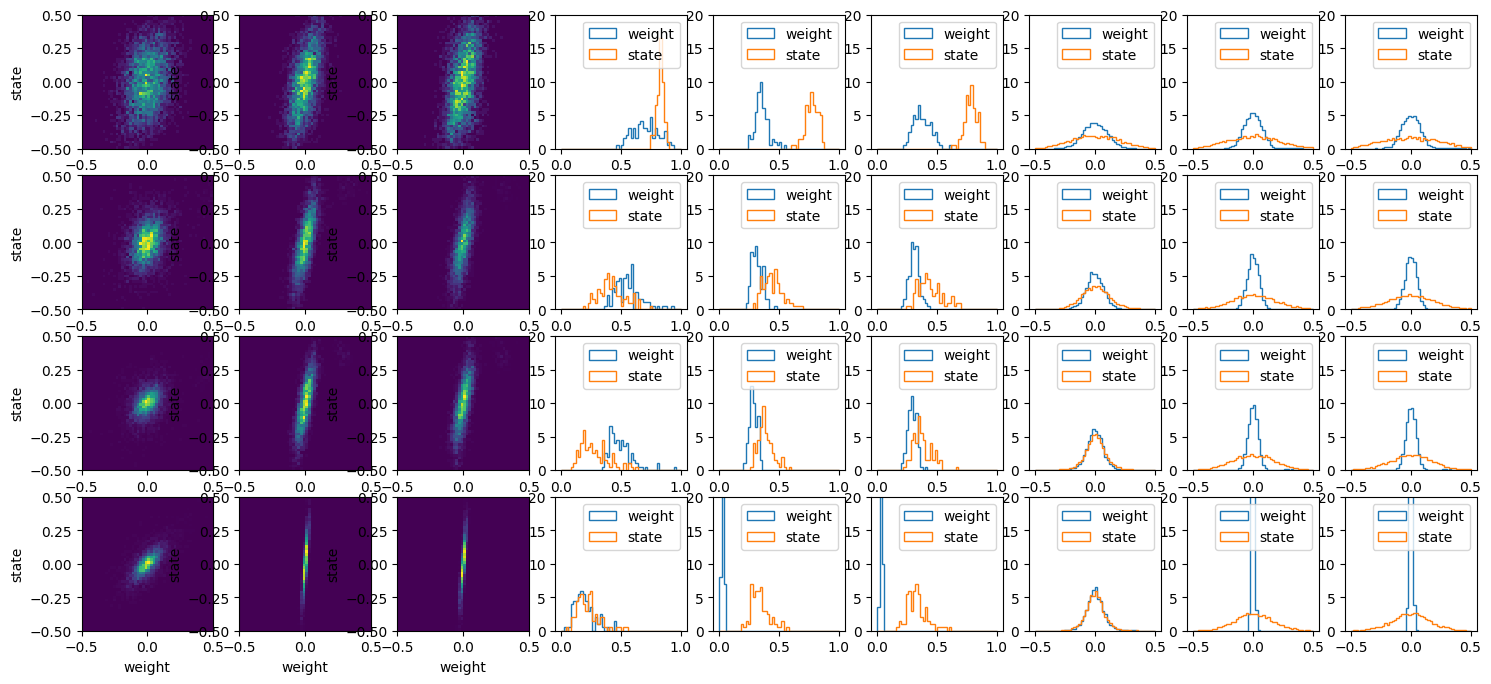

In [28]:
def get_state(m):
    return m.sum_2 / m.sum_0

def get_weight(m):
    w = m.weight
    return w.T @ w

num_layers = len(models[0]) // 4
num_models = len(models)

nrows = num_layers
ncols = num_models * 3

_, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(2*ncols, 2*nrows), dpi=100)
for i in range(num_layers):
    for j in range(num_models):
        x = get_weight(models[j][i*4+5])
        y = get_state(models[j][i*4+3])
        xd = x.detach().diagonal().numpy()
        yd = y.detach().diagonal().numpy()
        xo = x.detach().flatten().numpy()
        yo = y.detach().flatten().numpy()
        axes[i][j+num_models*0].hist2d(xo, yo, bins=(50, 50), range=((-.5, .5), (-.5, .5)))
        axes[i][j+num_models*0].set_xlabel("weight")
        axes[i][j+num_models*0].set_ylabel("state")
        axes[i][j+num_models*1].hist(xd, bins=50, range=(0, 1), density=True, histtype="step", label="weight")
        axes[i][j+num_models*1].hist(yd, bins=50, range=(0, 1), density=True, histtype="step", label="state")
        axes[i][j+num_models*1].set_ylim(0, 20)
        axes[i][j+num_models*1].legend()
        axes[i][j+num_models*2].hist(xo, bins=50, range=(-.5, .5), density=True, histtype="step", label="weight")
        axes[i][j+num_models*2].hist(yo, bins=50, range=(-.5, .5), density=True, histtype="step", label="state")
        axes[i][j+num_models*2].set_ylim(0, 20)
        axes[i][j+num_models*2].legend()